# Random Forest Model
By: Cara Piske F'21

This code was written to run a random forest model to determine vegetation controls on snowpack characteristics while accounting for terrain variables. See AGU 2021...


Snow depth was converted to a geotiff (from .asc) using the Kost. et al., 2019 processed ASO data. For the first test, we sampled only the open pixels, which were extracted from the Kost. snow classified by veg data converted to a geotiff as well (see convertFormat_calcTerrainVars.ipynb). <br>
NCALM data was downloaded, merged, and clipped to the ASO extent. It was then used to calculate slope, aspect, and northness (see convertFormat_calcTerrainVars.ipynb). <br>
SnowPalm-derived density was resampled to match the ASO grids. SWE was calculated by multiplying the snow density (g/cm3) / 1 (g/cm3) with depth (m)<br>
Kane et al. vegetation classification data (derived from FUSION metrics) was resampled using to a 1m grid and the extent of the ASO data (nearest neighbor resampling method)<br>

In [124]:
# import necessary packages
from osgeo import gdal
import pandas as pd
import os
import subprocess
import pdal
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculati
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import joblib
from sklearn import preprocessing
import multiprocessing as mp
import time
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import PartialDependenceDisplay
from pdpbox import pdp, get_dataset, info_plots
import seaborn as sns


In [2]:
#make sure we're in the right working directory
os.chdir('/')
print(os.getcwd())

W:\


## Load Data Save to Dataframe

In [3]:
# get geotransform and projection data
raster = gdal.Open("SCB/random_forest_data/calc_swe/SWE_20160326.tif")
gt = raster.GetGeoTransform()
proj = raster.GetProjection()
raster = None

In [4]:
# input - path = str. i.e. 'SCB/kane_veg_metrics/departure/14_withholes/departure_wh_clip2dem.tif'
# input - nd_value = int. no data value
# output - raster_arr = 1D array of raster values (maintaining columns)
def raster_to_array(path, nd_value):
    raster = gdal.Open(path) # open the file 
    raster_arr = raster.GetRasterBand(1).ReadAsArray() #read the first raster band (in this case we know we are only working with single bands) and read to a 2D array
    if raster_arr.dtype == 'int32':
        raster_arr = raster_arr.astype(float)
    raster_arr[raster_arr == nd_value] = np.nan # where the raster is equal to the provided no data value, set values to Nan
    raster_arr_flat = raster_arr.flatten() # flatten the array (row-wise)
    raster = None
    return raster_arr, raster_arr_flat

Snow Data

In [5]:
# define variable path
# fSCA_20160326_path = "SCB/random_forest_data/ASO_sd/ASO_snow_depth_20160326_30m.tif"
# fSCA_20160417_path = "SCB/random_forest_data/ASO_fsca/ASO_snow_classified_by_veg_20160417_warp2Dep.tif"
# fSCA_20160518_path = "SCB/random_forest_data/ASO_fsca/ASO_snow_classified_by_veg_20160518_warp2Dep.tif"

SWE_20160326_path = "SCB/random_forest_data/calc_swe/SWE_20160326.tif"
SWE_20160417_path = "SCB/random_forest_data/calc_swe/SWE_20160417.tif"
SWE_20160518_path = "SCB/random_forest_data/calc_swe/SWE_20160518.tif"

In [277]:
# Open data save to array
snowVeg_20160326_path = "SCB/random_forest_data/ASO_sd/ASO_snow_classified_by_veg_20160326_clp.tif"; [snowVeg_20160326_arr, snowVeg_20160326_flat] = raster_to_array(snowVeg_20160326_path, -9999)
snowVeg_20160417_path = "SCB/random_forest_data/ASO_sd/ASO_snow_classified_by_veg_20160417_clp.tif"; [snowVeg_20160417_arr, snowVeg_20160417_flat] = raster_to_array(snowVeg_20160417_path, -9999)
snowVeg_20160518_path = "SCB/random_forest_data/ASO_sd/ASO_snow_classified_by_veg_20160518_clp.tif"; [snowVeg_20160518_arr, snowVeg_20160518_flat] = raster_to_array(snowVeg_20160518_path, -9999)


[SWE_20160326_arr, SWE_20160326_flat] = raster_to_array(SWE_20160326_path, -9999)
[SWE_20160417_arr, SWE_20160417_flat] = raster_to_array(SWE_20160417_path, -9999)
[SWE_20160518_arr, SWE_20160518_flat] = raster_to_array(SWE_20160518_path, -9999)

Run below code to set all values not in the open (i.e. tall trees) to nans

the snow classified by veg has the following classifications: 0 - BE no snow; 25 - BE snow; 75 - tall tree no snow; 100 - tall tree snow

In [280]:
# # filter out only open pixels
# SWE_20160326_arr[snowVeg_20160326_arr >30 ] = np.nan; SWE_20160326_flat[snowVeg_20160326_flat >30 ] = np.nan
# SWE_20160417_arr[snowVeg_20160417_arr >30 ] = np.nan; SWE_20160417_flat[snowVeg_20160417_flat >30 ] = np.nan
# SWE_20160518_arr[snowVeg_20160518_arr >30 ] = np.nan; SWE_20160518_flat[snowVeg_20160518_flat >30 ] = np.nan

# # classify values is no canopy or canopy
snowVeg_20160326_flatb = snowVeg_20160326_flat
snowVeg_20160326_flatb[snowVeg_20160326_flatb <30 ] = 0
snowVeg_20160326_flatb[snowVeg_20160326_flatb >50 ] = 1
#snowVeg_20160326_flat = snowVeg_20160326_flat.astype(int)

**Terrain Data**

In [7]:
veg_dep_path = "SCB/random_forest_data/kane_veg/NCALM_veg_departure_clip2ASO_1m.tif"
veg_coreGap_path = "SCB/random_forest_data/kane_veg/NCALM_veg_raw_coreGap_clip2ASO_1m.tif"
veg_meanClumpSize_path = "SCB/random_forest_data/kane_veg/NCALM_veg_raw_meanClumpSize_clip2ASO_1m.tif"
veg_TAOperHa_path = "SCB/random_forest_data/kane_veg/NCALM_veg_raw_TAOperHa_clip2ASO_1m.tif"
elev_path = "SCB/random_forest_data/NCALM_terrain/NCALM_2014_be_clip2ASO.tif"
nness_path = "SCB/random_forest_data/NCALM_terrain/NCALM_2014_northness_clip2ASO.tif"

In [8]:
[veg_dep_arr, veg_dep_flat] = raster_to_array(veg_dep_path, -9999)
[veg_meanClumpSize_arr, veg_meanClumpSize_flat] = raster_to_array(veg_meanClumpSize_path, -9999)
[veg_TAOperHa_arr, veg_TAOperHa_flat] = raster_to_array(veg_TAOperHa_path, -9999)
[veg_coreGap_arr, veg_coreGap_flat] = raster_to_array(veg_coreGap_path, -9999)
[elev_arr, elev_flat] = raster_to_array(elev_path, -9999)
[nness_arr, nness_flat] = raster_to_array(nness_path, -9999)

In [22]:
# correct the elevation data
elev_flat[elev_flat < 100] = np.nan
elev_arr[elev_arr < 100 ] = np.nan
SWE_20160326_flat[SWE_20160326_flat < 0] =np.nan
SWE_20160326_flat[SWE_20160326_flat > 5000] = np.nan

In [23]:
# df_0326 = pd.DataFrame({'SWE':SWE_20160326_flat,'northness':nness_flat,'elev':elev_flat, 'veg_dep':veg_dep_flat, 'meanClumpSize':veg_meanClumpSize_flat, 'TAOperHa':veg_TAOperHa_flat, 'coreGap':veg_coreGap_flat})
# df_0326 = df_0326.dropna().reset_index(drop=True)
# # sklearn requires our "label" variable (target) to be a categorical or floating point variable. 
# # convert SWE values to cm
# df_0326["SWE_mm"] = df_0326.SWE * 1000
# # convert to integer 
# df_0326["SWE_mm"] = df_0326["SWE_mm"].astype("int") 


Because of spatial autocorrelation within the dataset, we want to choose an area of the raster to serve as our training dataset

For now we are only testing terrain varialbes (not vegetation)

we need to add in an raster with the latitude values of each pixel (center) in order to sort by latitude. We could theoretically do this by simply splitting the arrays 70% and 30% for the training and test arrays respectively however because we have quite a few nans (i.e. independence lake and biased open snow depths) we need to get rid of the nans before we separate the data

In [24]:
# gt[3] = coordinate of the upper lefthand corner of the upper lefthand pixel, gt[1]= resolution
lat_start = gt[3]-gt[1]/2
lat_stop = lat_start-elev_arr.shape[0]+1
# create dataframe and restructure                     
lat_arr = np.arange(lat_stop,lat_start+1,1); lat_arr = np.flip(lat_arr); lat_arr = np.transpose([lat_arr]*elev_arr.shape[1]); lat_flat = lat_arr.flatten()

In [25]:
# # lon
# lon_start = gt[0]+gt[1]/2
# lon_stop = lon_start+elev_arr.shape[1]-1
# lon_arr = np.arange(lon_start,lon_stop+1,1); lon_arr = np.tile(lon_arr,(elev_arr.shape[0],1)); lon_flat = lon_arr.flatten()

### Pre preocess the data
Running into memory issues, so let's filter the data as much as possible before putting into a dataframe

In [26]:
# because we know there are the most holes in the SWE data, let's filter for SWE nans
SWE_nans_0326 = ~np.isnan(SWE_20160326_flat)
SWE_nans_0417 = ~np.isnan(SWE_20160417_flat)
SWE_nans_0518 = ~np.isnan(SWE_20160518_flat)

In [ ]:
# # filter all datasets
# # for now, just flat data
# SWE_20160326_fil = SWE_20160326_flat[SWE_nans]
# SWE_20160518_fil = SWE_20160518_flat[~np.isnan(SWE_20160518_flat)]
# # veg_dep_fil = veg_dep_flat[SWE_nans]
# # veg_meanClumpSize_fil = veg_meanClumpSize_flat[SWE_nans]
# # veg_TAOperHa_fil = veg_TAOperHa_flat[SWE_nans]
# # veg_coreGap_fil = veg_coreGap_flat[SWE_nans]
# elev_fil = elev_flat[SWE_nans]
# nness_fil = nness_flat[SWE_nans]
# lat_fil = lat_flat[SWE_nans]
# lon_fil = lon_flat[SWE_nans]

In [27]:
# the 2014 density product has a band of values outside of the main study zone that we have to filter out - luckily we know the lat and long of the band. (this will be very inefficient for now)
SWE_20160417_arr[lat_arr >= 4372000] = np.nan
SWE_20160417_arr[lon_arr >= 738590] = np.nan
SWE_20160417_flat = SWE_20160417_arr.flatten()
SWE_20160417_fil = SWE_20160417_flat[~np.isnan(SWE_20160417_flat)]

sort by lat ascending, mean = 300, descending = 410

lat 621, ascending T, train<br>
lat 327.88, ascending T, test<br>
lat 409.80, ascending F, train<br>
lat 824.02, ascending F, test<br>

lon 636.39, ascending T, train<br>
lon 292.449, ascending T, test<br>
lon 366.13, ascending F, train<br>
lon 926.06, ascending F, test<br>

In [538]:
def RF_dataset_creation(var_list, var_list_str, feature_list, label_list):
    # create a dataframe from the arrays
    df = pd.DataFrame()
    i = 0
    for files in var_list:
        name = var_list_str[i]
        df[name] = files
        i = i+1
    
    # data cannot contain nans; sklearn requires our "label" variable (target) to be a categorical or floating point variable. 
    df = df.dropna(subset=feature_list).reset_index(drop=True)
    df["SWE_mm"] = df["SWE"] *1000
    df["SWE_mm"] = df["SWE_mm"].astype("int")
    # sort by lat
    #df = df.sort_values(by=['lat'], ascending=False).reset_index(drop = True)
    #df = df.sort_values(by=['elev'], ascending=True).reset_index(drop = True)
    #df = df[df['elev'] >= 2400]
    #df = df[df['elev'] < 2400]
    df = df.sort_values(by=['lat'], ascending=False).reset_index(drop = True)
    # calculate row cutoff
    train_cutoff = round(len(df)*0.7)
    # we want our training dataset to be the bottom 70% of the raster, so we will define the training df as the top 70% of the latitudes
    train_df = df.iloc[0:train_cutoff]
    # wwe want our testing dataset to be the top 30% of the raster, so we will define the testing df as the bottom 30% of the latitudes
    test_df = df.iloc[train_cutoff:len(df)+1]
    all_df = df

    lab_train = train_df[label_list]
    lab_enc = preprocessing.LabelEncoder()
    lab_train_enc = lab_enc.fit_transform(lab_train)
    #lab_train_enc = lab_train_enc.reshape(-1,1)
    feat_train = train_df[feature_list]
    
    lab_test = test_df[label_list]
    feat_test = test_df[feature_list]
    test_all = test_df
    return(lab_train_enc, feat_train, lab_test, feat_test, df)

In [539]:
var_list = [SWE_20160326_flat[SWE_nans_0326], elev_flat[SWE_nans_0326], nness_flat[SWE_nans_0326],snowVeg_20160326_flatb[SWE_nans_0326], lat_flat[SWE_nans_0326], veg_meanClumpSize_flat[SWE_nans_0326], veg_TAOperHa_flat[SWE_nans_0326], veg_coreGap_flat[SWE_nans_0326], veg_dep_flat[SWE_nans_0326]]
var_list_str = ["SWE","elev","nness","canopy_class","lat", "clump_size","TAOperHa","coreGap", "veg_dep"]
feature_list = ["elev","nness"]#, "clump_size" ,"TAOperHa","coreGap"]
label_list = "SWE_mm"
[lab_train_20160326, feat_train_20160326, lab_test_20160326, feat_test_20160326, test_all_20160326] = RF_dataset_creation(var_list, var_list_str, feature_list, label_list)

In [546]:
feat_test_20160326[['elev','nness']]

,elev,nness
4219606,2193.418457,0.122118
4219607,2207.635254,0.047845
4219608,2208.509521,0.023012
4219609,2209.257080,0.100221
4219610,2210.605713,0.073422
...,...,...
6028003,2267.433350,-0.278378
6028004,2282.133789,-0.290327
6028005,2273.973145,-0.400422
6028006,2276.633545,-0.291743


In [305]:
# convert canopy class to int
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [319]:
column_trans = make_column_transformer((OneHotEncoder(), ['canopy_class']), remainder = "passthrough")
column_trans = column_trans.fit_transform(feat_train_20160326b)

In [49]:
# var_list = [SWE_20160417_flat[SWE_nans_0417], elev_flat[SWE_nans_0417], nness_flat[SWE_nans_0417], lat_flat[SWE_nans_0417], veg_meanClumpSize_flat[SWE_nans_0417], veg_TAOperHa_flat[SWE_nans_0417], veg_coreGap_flat[SWE_nans_0417]]
# var_list_str = ["SWE","elev","nness","lat", "clump_size","TAOperHa","coreGap"]
# feature_list = ["elev","nness"]#, "clump_size" ,"TAOperHa","coreGap"]
# label_list = "SWE_mm"
# [lab_train_20160417, feat_train_20160417, lab_test_20160417, feat_test_20160417, test_all_20160417] = RF_dataset_creation(var_list, var_list_str, feature_list, label_list)

In [50]:
# var_list = [SWE_20160518_flat[SWE_nans_0518], elev_flat[SWE_nans_0518], nness_flat[SWE_nans_0518], lat_flat[SWE_nans_0518], veg_meanClumpSize_flat[SWE_nans_0518], veg_TAOperHa_flat[SWE_nans_0518], veg_coreGap_flat[SWE_nans_0518]]
# var_list_str = ["SWE","elev","nness","lat", "clump_size","TAOperHa","coreGap"]
# feature_list = ["elev","nness"]#, "clump_size" ,"TAOperHa","coreGap"]
# label_list = "SWE_mm"
# [lab_train_20160518, feat_train_20160518, lab_test_20160518, feat_test_20160518, test_all_20160518] = RF_dataset_creation(var_list, var_list_str, feature_list, label_list)

## Now time for RFM!!

In [ ]:
print("Number of processors: ", mp.cpu_count())

In [62]:
#Create a Gaussian Classifier
def rf(feat_train, lab_train):
    rf_mod=RandomForestClassifier(n_estimators=10, random_state = 42, max_depth=3)
    #Train the model using the training sets y_pred=clf.predict(X_test)
    rf_mod.fit(feat_train, lab_train)

dec n_est from 700 to 600 and max depth to 8, time = 464, abs error = 153.86 degrees <br>
n_est 800, max depth to 8, time = 620, MAE = 153.75 degrees <br>
n_est 800, max depth to 9, time = 687, MAE = 157.02 degrees <br>
n_est 800, max depth to 9, time = 567, MAE = 153.05 degrees (elev/northness/tree clump) <br>
n_est 800, max depth to 10, time = 749.7, MAE = 153.05 degrees (elev/northness/tree clump) <br>

n_est 800, max depth to 10, time = 538.22, MAE = 148.74 degrees (elev/northness) <br>
n_est 800, max depth to 10, time = 742.22, MAE = 148.74 degrees (elev/northness/allveg) <br>

with only open pixels <br> 
n_est 800, max depth to 10, time = 617.96, MAE = 148.74 degrees, RMSE = 266.9 (elev/northness/allveg) <br>


with all pixels<br>
n_est 800, max depth to 10, time = 542.21, MAE = 148.74 degrees (elev/northness) <br>

In [536]:
# # 21 seconds with n_estimators = 10, n_jobs = 20; 179 with n_jobs not specified; 114 with njobs = 24, n_estimators = 100; 498 with n_estimators = 500
start = time.time()
#Create a Gaussian Classifier
rf_0326=RandomForestRegressor(n_estimators=800, random_state = 42,n_jobs = 24, max_depth = 10)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_0326.fit(feat_train_20160326, lab_train_20160326)
end = time.time()

In [537]:
end-start

528.8007369041443

In [76]:
joblib.dump(rf_0326, "SCB/random_forest_data/rf_0326.joblib")

['SCB/random_forest_data/rf_0326.joblib']

In [ ]:
# # 21 seconds with n_estimators = 10, n_jobs = 20; 179 with n_jobs not specified; 114 with njobs = 24, n_estimators = 100; 498 with n_estimators = 500
start = time.time()
#Create a Gaussian Classifier
rf_0417=RandomForestRegressor(n_estimators=800, random_state = 42,n_jobs = 24, max_depth = 10)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_0417.fit(feat_train_20160417, lab_train_20160417)
end = time.time()

In [ ]:
end-start

In [ ]:
joblib.dump(rf_0417, "SCB/random_forest_data/rf_0417.joblib")

In [ ]:
# time = 345
start = time.time()
#Create a Gaussian Classifier
rf_0518=RandomForestClassifier(n_estimators=800, random_state = 42,n_jobs = 24, max_depth = 3)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_0518.fit(feat_train_20160518, lab_train_20160518)
end = time.time()

In [ ]:
joblib.dump(rf_0518, "SCB/random_forest_data/rf_0518.joblib")

## Predictions

rf_0326_2600m, rf_0326_2400m, rf_0326_2200m, rf_0326_2000m

In [547]:
# Use the forest's predict method on the test data
predictions_0326 = rf_0326.predict(test_all_20160326[['elev','nness']])
#predictions_0417 = rf_0417.predict(feat_test_20160417[0:1000000])
#predictions_0518 = rf_0518.predict(feat_test_20160518)

In [548]:
np.mean(predictions_0326)

518.3329855871397

In [550]:
# plt.scatter(predictions_0326, lab_test_20160326.values)

In [551]:
test_all_20160326

,SWE,elev,nness,canopy_class,lat,clump_size,TAOperHa,coreGap,veg_dep,SWE_mm
0,0.402499,2152.760742,-0.006218,0.0,4371764.0,5.834646,313.580247,1.666667,NaN,402
1,0.434483,2152.741943,-0.008408,0.0,4371763.0,5.834646,313.580247,1.666667,NaN,434
2,0.502355,2152.890381,-0.013642,0.0,4371763.0,5.834646,313.580247,1.666667,NaN,502
3,0.000000,2152.710449,0.003534,0.0,4371763.0,5.834646,313.580247,1.666667,NaN,0
4,0.764976,2152.847412,0.034609,0.0,4371762.0,5.834646,313.580247,1.666667,NaN,764
...,...,...,...,...,...,...,...,...,...,...
6028003,0.000000,2267.433350,-0.278378,0.0,4365310.0,1.588785,132.098765,4.666667,1.109271,0
6028004,0.073725,2282.133789,-0.290327,0.0,4365310.0,3.929134,156.790123,1.555556,1.568687,73
6028005,0.076350,2273.973145,-0.400422,0.0,4365309.0,2.944882,156.790123,3.333333,1.446452,76
6028006,0.057300,2276.633545,-0.291743,0.0,4365309.0,2.944882,156.790123,3.333333,1.446452,57


In [588]:
# # Use the forest's predict method on the test data
# predictions_0326 = rf_0326.predict(feat_test_20160326)
# Calculate the absolute errors
errors_0326 = test_all_20160326['SWE_mm'] - predictions_0326
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_0326), 2), 'degrees.')
rmse_0326 = np.sqrt(sum(np.square(errors_0326))/len(errors_0326))
print(rmse_0326)

Mean Absolute Error: 28.91 degrees.
249.18863364355093


## Visualizations

#### save tree

In [334]:
rf_0326.estimators_[10]

DecisionTreeRegressor(max_depth=10, max_features='auto', random_state=669991378)

In [335]:

# Pull out one tree from the forest
tree = rf_0326.estimators_[10]

# Pull out one tree from the forest
tree = rf_0326.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')


#### importance plot

In [553]:
# Get numerical feature importances
importances = list(rf_0326.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: elev                 Importance: 0.85
Variable: nness                Importance: 0.15


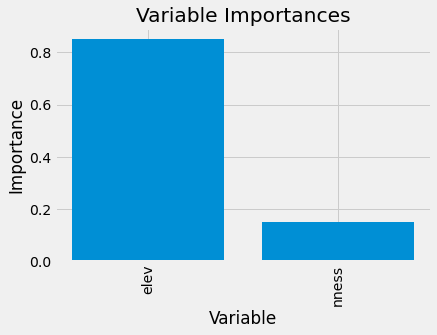

In [554]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Partial Difference Plots

AttributeError: 'dict' object has no attribute 'xlabel'

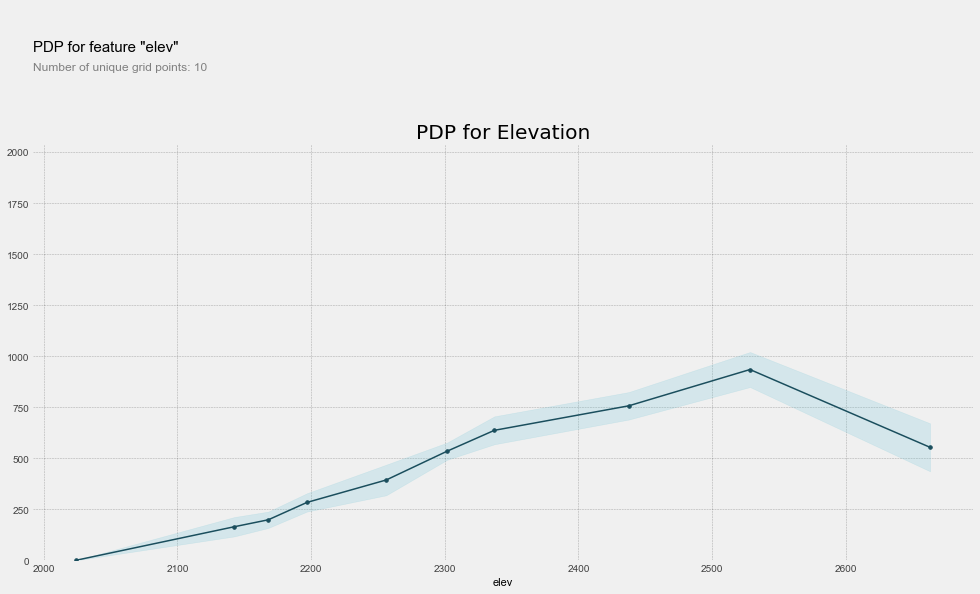

In [569]:
pdp_dist = pdp.pdp_isolate(model=rf_0326, dataset=feat_test_20160326, model_features=feature_list, feature="elev")
pdp_plt, axes = pdp.pdp_plot(pdp_dist, "elev")
plt.title("PDP for Elevation")
axes.xlabel("Elevation (m)")
#axes.show()
#pdp.plt.savefig('AGU/box_figs/rf_results/pdp_elev.png', dpi=200)


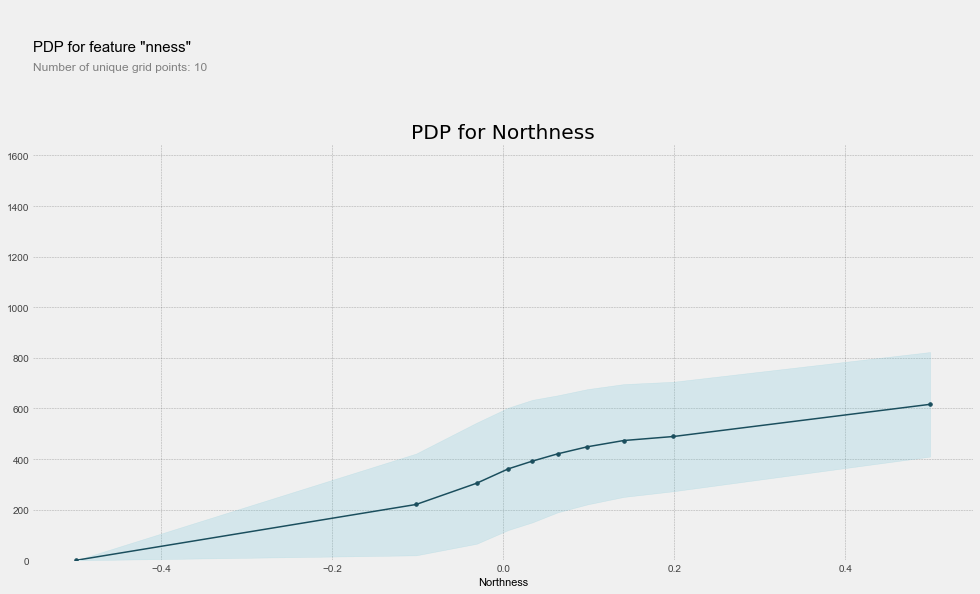

<Figure size 432x288 with 0 Axes>

In [568]:
pdp_dist = pdp.pdp_isolate(model=rf_0326, dataset=feat_test_20160326, model_features=feature_list, feature="nness")

pdp.pdp_plot(pdp_dist, "nness")
plt.title("PDP for Northness")
plt.xlabel("Northness")
plt.show()
pdp.plt.savefig('AGU/box_figs/rf_results/pdp_nness.png', dpi=200)


## Erros vs veg

In [555]:
test_all_20160326['errors'] = errors_0326

In [556]:
# elevation, either enter number of bins desired or desired width 
elev_bin_target = 50
elev_bin_val = (max(test_all_20160326['elev']) - min(test_all_20160326['elev']))/elev_bin_target
# or create discrete bins using rounded values
elev_bins_set = np.arange(round(min(test_all_20160326['elev'])), round(max(test_all_20160326['elev']))+elev_bin_target, elev_bin_target)
elev_bins_set = ([2000,2100,2200,2300,2400,2500,2600])
# departure
departure_bins_set = ([-4, -2, -1, 1, 2, 4 ])
nness_bins_set = np.linspace(-round(np.nanmax(test_all_20160326['nness']),1), round(np.nanmax(test_all_20160326['nness']),1),num=5)
clump_size_bins = ([0, 3, 6, 9, 12, 15, 50])
TOA_size_bins = ([0, 50, 100, 150, 200, 300, 500])
coreGap_bins = ([0, 3, 6, 9, 12, 15, 50])


In [557]:
elev_bins_set

[2000, 2100, 2200, 2300, 2400, 2500, 2600]

In [558]:
round(min(test_all_20160326['elev']))

1918

In [559]:
test_all_20160326['nness_bins'] = pd.cut(test_all_20160326['nness'], bins=nness_bins_set, right = False,include_lowest= True)
test_all_20160326['elev_bins'] = pd.cut(test_all_20160326['elev'], bins=elev_bins_set, right = False,include_lowest= True)
test_all_20160326['clump_size_bins'] = pd.cut(test_all_20160326['clump_size'], bins=clump_size_bins, right = False,include_lowest= True)
test_all_20160326['TOA_size_bins'] = pd.cut(test_all_20160326['TAOperHa'], bins=TOA_size_bins, right = False,include_lowest= True)
test_all_20160326['coreGap_bins'] = pd.cut(test_all_20160326['coreGap'], bins=coreGap_bins, right = False,include_lowest= True)
test_all_20160326['vegDep_bins'] = pd.cut(test_all_20160326['veg_dep'], bins=departure_bins_set, right = False,include_lowest= True)

(array([  658267.,  5671924., 12316287., 18904147.,  8047130.,  5797494.,
         2942608.,  1856568.,  1650230.,   527146.]),
 array([1839.8645, 1923.7709, 2007.6772, 2091.5835, 2175.49  , 2259.3962,
        2343.3025, 2427.209 , 2511.1152, 2595.0217, 2678.928 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

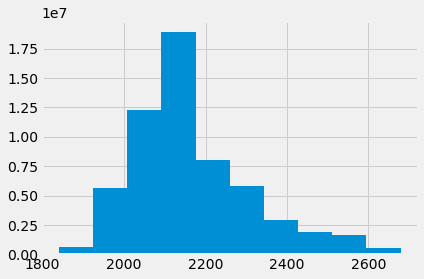

In [416]:
plt.hist(elev_flat)

(array([169375., 311305., 317364., 273256., 246857., 347697., 387746.,
        238633., 128157.,  96583.]),
 array([2000.    , 2019.9999, 2039.9998, 2059.9995, 2079.9995, 2099.9995,
        2119.9993, 2139.999 , 2159.999 , 2179.999 , 2199.9988],
       dtype=float32),
 <BarContainer object of 10 artists>)

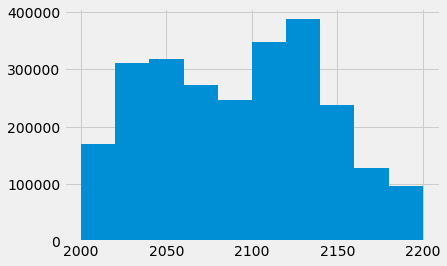

In [410]:
plt.hist(feat_train_20160326['elev'])

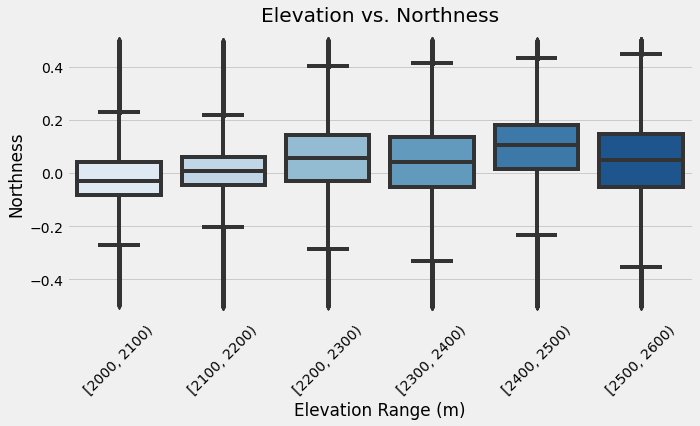

In [560]:
elev_nness_box, axes = plt.subplots(1,1,figsize=(10, 5), sharey=False) # create a figure axis
# we want a scatterplot
# specify figure axis (ax=axes)
# data = dataframe name, x = dataframe column name, y = dataframe column name
# hue = color values by variable, marker = specify style, s = size of marker, palette = color palette

sns.boxplot(ax=axes, data=test_all_20160326, x='elev_bins', y="nness", palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Elevation vs. Northness')
axes.set(xlabel = 'Elevation Range (m)',ylabel = 'Northness')
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45);
#plt.legend(title= 'northness');

#elev_nness_box.savefig('lidar_processing/python_scripts/snow_departure_project/figures/elev_nness_box.png')


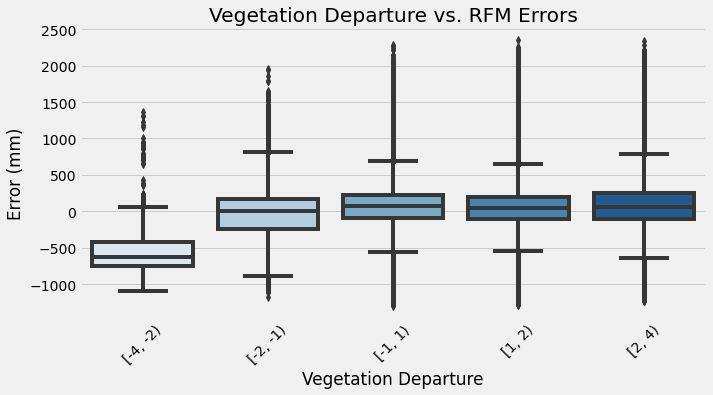

In [482]:
elev_nness_box, axes = plt.subplots(1,1,figsize=(10, 5), sharey=False) # create a figure axis
# we want a scatterplot
# specify figure axis (ax=axes)
# data = dataframe name, x = dataframe column name, y = dataframe column name
# hue = color values by variable, marker = specify style, s = size of marker, palette = color palette

sns.boxplot(ax=axes, data=test_all_20160326, x='vegDep_bins', y="errors", palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Vegetation Departure vs. RFM Errors')
axes.set(xlabel = 'Vegetation Departure',ylabel = 'Error (mm)')
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45);
#plt.legend(title= 'northness');

#elev_nness_box.savefig('lidar_processing/python_scripts/snow_departure_project/figures/elev_nness_box.png')


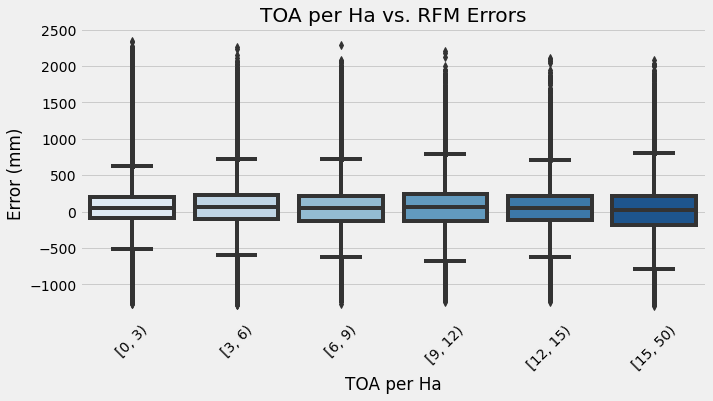

In [483]:
elev_nness_box, axes = plt.subplots(1,1,figsize=(10, 5), sharey=False) # create a figure axis
# we want a scatterplot
# specify figure axis (ax=axes)
# data = dataframe name, x = dataframe column name, y = dataframe column name
# hue = color values by variable, marker = specify style, s = size of marker, palette = color palette

sns.boxplot(ax=axes, data=test_all_20160326, x='coreGap_bins', y="errors", palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('TOA per Ha vs. RFM Errors')
axes.set(xlabel = 'TOA per Ha',ylabel = 'Error (mm)')
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45);
#plt.legend(title= 'northness');

#elev_nness_box.savefig('lidar_processing/python_scripts/snow_departure_project/figures/elev_nness_box.png')


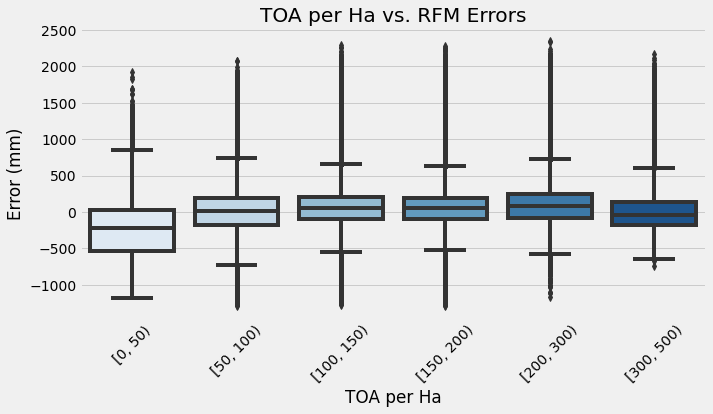

In [349]:
elev_nness_box, axes = plt.subplots(1,1,figsize=(10, 5), sharey=False) # create a figure axis
# we want a scatterplot
# specify figure axis (ax=axes)
# data = dataframe name, x = dataframe column name, y = dataframe column name
# hue = color values by variable, marker = specify style, s = size of marker, palette = color palette

sns.boxplot(ax=axes, data=test_all_20160326, x='TOA_size_bins', y="errors", palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('TOA per Ha vs. RFM Errors')
axes.set(xlabel = 'TOA per Ha',ylabel = 'Error (mm)')
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45);
#plt.legend(title= 'northness');

#elev_nness_box.savefig('lidar_processing/python_scripts/snow_departure_project/figures/elev_nness_box.png')


In [611]:
sns.set_style("whitegrid")
#sns.set(font_scale = 1)


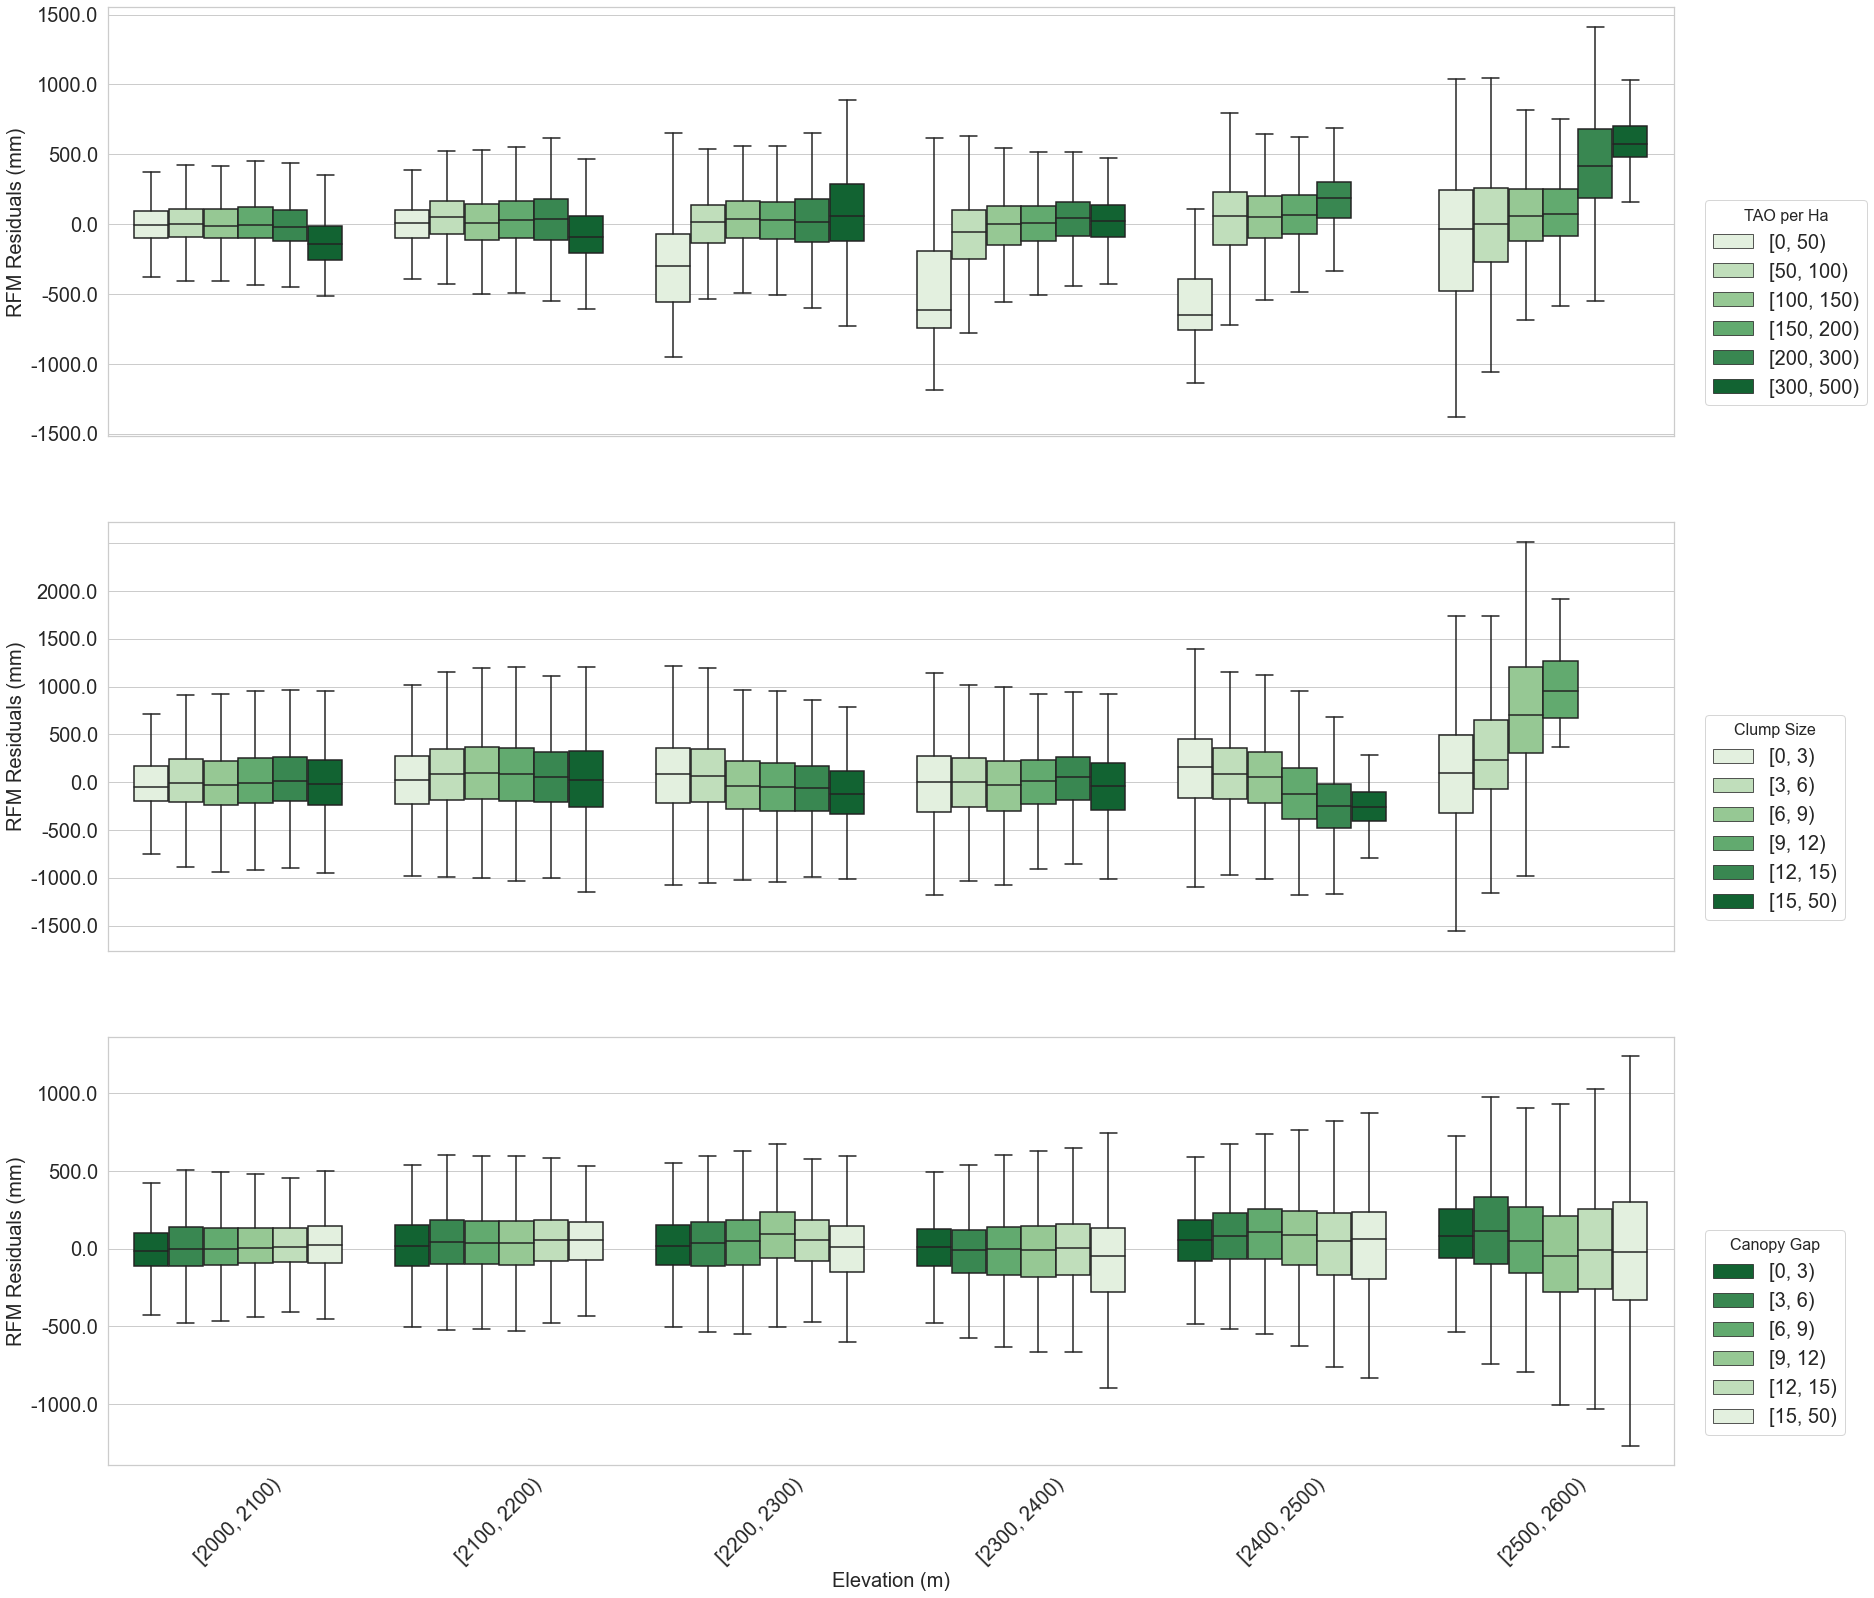

In [612]:
errors_veg, axes = plt.subplots(3,1,figsize=(25, 25), sharey=False) # create a figure axis
# we want a scatterplot
# specify figure axis (ax=axes)
# data = dataframe name, x = dataframe column name, y = dataframe column name
# hue = color values by variable, marker = specify style, s = size of marker, palette = color palette
# sns.boxplot(ax=axes[0], data=test_all_20160326, x='elev_bins', y="errors", hue = 'vegDep_bins', palette = 'Greens')
sns.boxplot(ax=axes[0], data=test_all_20160326, x='elev_bins', y="errors", hue = 'TOA_size_bins',showfliers = False, palette = 'Greens')
#axes[0].set_title('a')
axes[0].set_xlabel('')
axes[0].set_ylabel('RFM Residuals (mm)', fontsize = 20)
axes[0].set_yticklabels(axes[0].get_yticks(),size = 20);
axes[0].set_xticklabels([]);

axes[0].legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0,title= 'TAO per Ha', fontsize = 20, title_fontsize = 16);

sns.boxplot(ax=axes[1], data=test_all_20160326, x='elev_bins', y="errors", hue = 'clump_size_bins',showfliers = False, palette = 'Greens')
#axes[1].set_title('b', fontsize = )
axes[1].set_xlabel('')
axes[1].set_ylabel('RFM Residuals (mm)', fontsize = 20)
axes[1].set_xticklabels([]);
axes[1].set_yticklabels(axes[0].get_yticks(),size = 20);
axes[1].legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0,title= 'Clump Size', fontsize = 20, title_fontsize = 16);

sns.boxplot(ax=axes[2], data=test_all_20160326, x='elev_bins', y="errors", hue = 'coreGap_bins',showfliers = False, palette = 'Greens_r')
#axes[2].set_title('c')
axes[2].set_xlabel('Elevation (m)', fontsize = 20)
axes[2].set_ylabel('RFM Residuals (mm)', fontsize = 20)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation = 45, fontsize = 20);
axes[2].set_yticklabels(axes[2].get_yticks(),size = 20);
axes[2].legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0,title= 'Canopy Gap', fontsize = 20, title_fontsize = 16);

# sns.boxplot(ax=axes[3], data=test_all_20160326, x='elev_bins', y="errors", hue = 'vegDep_bins',showfliers = False, palette = 'Greens')
# axes[3].set_title('d')
# axes[3].set(xlabel = '',ylabel = 'RFM Residuals (mm)')
# #axes[1].set_xticklabels(axes.get_xticklabels(),rotation = 45);
# axes[3].legend(loc = 2,title= 'Vegetation Departure');


errors_veg.savefig('AGU/box_figs/rf_results/errors_veg.png', transparent=True,bbox_inches='tight')